Pytorch를 사용한 LSTM 텍스트 분류<br>
https://ichi.pro/ko/pytorchleul-sayonghan-lstm-tegseuteu-bunlyu-48844070948800

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

# Model
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

#training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

ModuleNotFoundError: No module named 'torchtext.legacy'

In [2]:
data = pd.read_csv('./unethical_change_label.csv')

In [3]:
data.columns

Index(['Unnamed: 0', 'Column1', 'lbl', 'sentence', 'speaker'], dtype='object')

In [4]:
data = data[['sentence','lbl']]

In [7]:
data.rename(columns={'lbl':'label'})

,sentence,label
0,틀딱 할저씨들 왜케 낮에 술마시고 쳐돌아다님?,"비난,혐오"
1,술쳐마셨으면 한강가서 재기나 하지,"비난,폭력,혐오"
2,한순간이라도 맨정신이면 버티기 힘든 인생이라 그런가봄,비난
3,한남들 _케 앞 안보고 다니냐 진짜 비켜주는 사람을 본적이 없음,"비난,혐오"
4,기본 사회 매너가 진짜 없는 듯 희한함,비도덕 아님
...,...,...
9968,아픈건 알겠는데 왜 옆사람 신경쓰이게 징징거리냐,비난
9969,좀 참을줄도 알지 그시기니까 예민하다 뭐다;; 그냥 성격이 파탄난거 같은데,"비난,혐오"
9970,성괴들 유튜브 진출을 막아야한다!,"비난,혐오"
9971,개나 소나 얼굴 고치고 돈 좀 쉽게 벌려고 하네,비난


In [5]:
data

,sentence,lbl
0,틀딱 할저씨들 왜케 낮에 술마시고 쳐돌아다님?,"비난,혐오"
1,술쳐마셨으면 한강가서 재기나 하지,"비난,폭력,혐오"
2,한순간이라도 맨정신이면 버티기 힘든 인생이라 그런가봄,비난
3,한남들 _케 앞 안보고 다니냐 진짜 비켜주는 사람을 본적이 없음,"비난,혐오"
4,기본 사회 매너가 진짜 없는 듯 희한함,비도덕 아님
...,...,...
9968,아픈건 알겠는데 왜 옆사람 신경쓰이게 징징거리냐,비난
9969,좀 참을줄도 알지 그시기니까 예민하다 뭐다;; 그냥 성격이 파탄난거 같은데,"비난,혐오"
9970,성괴들 유튜브 진출을 막아야한다!,"비난,혐오"
9971,개나 소나 얼굴 고치고 돈 좀 쉽게 벌려고 하네,비난


In [6]:
data.describe()

,lbl,sentence
count,9973,9973
unique,84,9968
top,비난,왜 무슨 일이야?
freq,3235,4


In [7]:
lblist = list(data['lbl'].unique())

In [34]:
lblist[0]

'비난,혐오'

In [8]:
data['label'] = data['lbl'].apply(lambda x: lblist.index(x))

In [9]:
data = data[['sentence','label']]

In [10]:
train,test = train_test_split(data,train_size = 0.9)

In [11]:
train

,sentence,label
7311,아비가 싸튀충이었나보네,15
4243,아비 봐도 양비론적 생각이 사회악이다,0
3066,얼굴도 못생겼고 좀 뚱뚱한거 보니까 노래 엄청 잘하나보네?,2
4294,한녀들 성적해방전사로 아프간 군인들꺼가 필요하긔,11
564,웅얼거리면서 가사 전달도 잘 안되고.. 듣기 거북함,2
...,...,...
4883,ㅋㅋㅋ 얼마나 인재가 없으면 여당에서 버리는 대로 줍줍하네 ㅋㅋㅋ,2
5577,발냄새때문에 공기 오염되느중..,2
7500,역시 한남들 수준ㅋㅋ 논리로 후달리니까 또 인신 공격하지,0
6793,뇌는 옵션인가?,2


In [12]:
train.to_csv('./lstm_84_train.csv')

In [13]:
test.to_csv('./lstm_84_test.csv')

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Fields
id_field = Field(sequential = False,
                 use_vocab = False) # 실제 사용은 하지 않을 예정
label_field = Field(sequential=False, use_vocab = False,dtype=torch.long)
text_field = Field(sequential=True,
             use_vocab=True,
             tokenize=str.split, lower = True, include_lengths = True, batch_first = True,dtype = torch.long)


fields = [('id',id_field),('sentence',text_field),('labels',label_field)]


In [16]:
train

,sentence,label
7311,아비가 싸튀충이었나보네,15
4243,아비 봐도 양비론적 생각이 사회악이다,0
3066,얼굴도 못생겼고 좀 뚱뚱한거 보니까 노래 엄청 잘하나보네?,2
4294,한녀들 성적해방전사로 아프간 군인들꺼가 필요하긔,11
564,웅얼거리면서 가사 전달도 잘 안되고.. 듣기 거북함,2
...,...,...
4883,ㅋㅋㅋ 얼마나 인재가 없으면 여당에서 버리는 대로 줍줍하네 ㅋㅋㅋ,2
5577,발냄새때문에 공기 오염되느중..,2
7500,역시 한남들 수준ㅋㅋ 논리로 후달리니까 또 인신 공격하지,0
6793,뇌는 옵션인가?,2


In [17]:
# Tabular Dataset
train,test = TabularDataset.splits(path = './', train = 'lstm_84_train.csv',test = 'lstm_84_test.csv',format = 'CSV',fields = fields, skip_header=True)


In [18]:
train_iter = BucketIterator(train, batch_size = 32, device = device, sort_key=lambda x: len(x.sentence),shuffle=True, sort_within_batch = True)
test_iter = BucketIterator(test, batch_size = 32, device = device, sort_key=lambda x: len(x.sentence),shuffle=True, sort_within_batch = True)


In [19]:
text_field.build_vocab(train)

# Model

In [20]:
class LSTM(nn.Module):
    def __init__(self,dimension=128):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(len(text_field.vocab),32)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size = 32,hidden_size = dimension,num_layers=1,batch_first = True,bidirectional = True)
        
        self.drop = nn.Dropout(p=0.5)
        
        self.fc = nn.Linear(2*dimension,len(lblist))
        
    def forward(self,text,text_len):
        text_emb = self.embedding(text)
        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_out = torch.squeeze(text_fea, 1)
        

        return text_out
        

In [21]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [35]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = test_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = '.',
          best_valid_loss = float("Inf"),
          ):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    
    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (i,(text,text_len),label),_ in train_loader:
                labels = label.to(device)
                output = model(text, text_len)

                loss = criterion(output, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update running values
                running_loss += loss.item()
                global_step += 1

                # evaluation step
                if global_step % eval_every == 0:
                    model.eval()
                    with torch.no_grad():                    
                      # validation loop
                         for (i,(text,text_len),label),_  in train_loader:
                            labels = label.to(device)
                            output = model(text, text_len)
                            loss = criterion(output, labels)
                            valid_running_loss += loss.item()

                    # evaluation
                    average_train_loss = running_loss / eval_every
                    average_valid_loss = valid_running_loss / len(valid_loader)
                    train_loss_list.append(average_train_loss)
                    valid_loss_list.append(average_valid_loss)
                    global_steps_list.append(global_step)

                    # resetting running values
                    running_loss = 0.0                
                    valid_running_loss = 0.0
                    model.train()

                    # print progress
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                                  average_train_loss, average_valid_loss))

                    # checkpoint
                    if best_valid_loss > average_valid_loss:
                        best_valid_loss = average_valid_loss
                        save_checkpoint(file_path + '/84_model.pt', model, optimizer, best_valid_loss)
                        save_metrics(file_path + '/84_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/84_metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=20)


Epoch [1/20], Step [140/5620], Train Loss: 2.6663, Valid Loss: 18.8344
Model saved to ==> ./84_model.pt
Model saved to ==> ./84_metrics.pt
Epoch [2/20], Step [280/5620], Train Loss: 2.1346, Valid Loss: 18.4112
Model saved to ==> ./84_model.pt
Model saved to ==> ./84_metrics.pt
Epoch [3/20], Step [420/5620], Train Loss: 2.1012, Valid Loss: 18.1207
Model saved to ==> ./84_model.pt
Model saved to ==> ./84_metrics.pt
Epoch [4/20], Step [560/5620], Train Loss: 2.0436, Valid Loss: 17.7584
Model saved to ==> ./84_model.pt
Model saved to ==> ./84_metrics.pt
Epoch [5/20], Step [700/5620], Train Loss: 2.0181, Valid Loss: 17.3657
Model saved to ==> ./84_model.pt
Model saved to ==> ./84_metrics.pt
Epoch [6/20], Step [840/5620], Train Loss: 1.9997, Valid Loss: 17.1020
Model saved to ==> ./84_model.pt
Model saved to ==> ./84_metrics.pt
Epoch [7/20], Step [980/5620], Train Loss: 1.9478, Valid Loss: 16.3325
Model saved to ==> ./84_model.pt
Model saved to ==> ./84_metrics.pt
Epoch [8/20], Step [1120/56

In [36]:
text_field.vocab['부산출신']

14125

Model loaded from <== ./84_metrics.pt


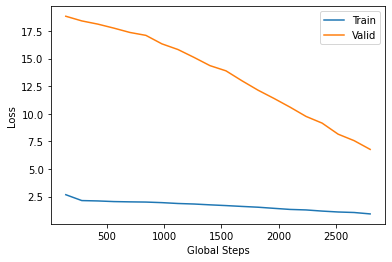

In [37]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('.' + '/84_metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== ./84_model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.2348    0.9774    0.3786       221
           1     0.0000    0.0000    0.0000        11
           2     0.3421    0.0841    0.1351       309
           3     0.0000    0.0000    0.0000       196
           5     0.0000    0.0000    0.0000         9
           6     0.0000    0.0000    0.0000         5
           7     0.0000    0.0000    0.0000        69
           8     0.0000    0.0000    0.0000         5
           9     0.0000    0.0000    0.0000         3
          10     0.0000    0.0000    0.0000         2
          11     0.0000    0.0000    0.0000        15
          12     0.0000    0.0000    0.0000        13
          13     0.0000    0.0000    0.0000        37
          14     0.0000    0.0000    0.0000         4
          15     0.0000    0.0000    0.0000        14
          18     0.0000    0.0000    0.0000        11
          19     0.000

/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/lightweight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


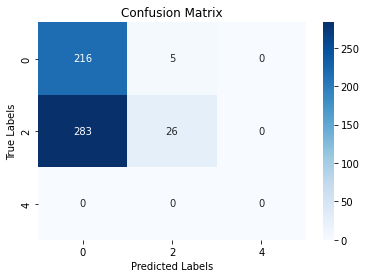

In [47]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5,category_num=0):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (i,(text, text_len),labels),_ in test_loader:           
            labels = labels.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(torch.argmax(output,axis = 1).tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0,2,4])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    # plt.figure(figsize = (1000,1000))
    ax.xaxis.set_ticklabels([0,2,4])
    ax.yaxis.set_ticklabels([0,2,4])
    
  
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('.' +'/84_model.pt', best_model, optimizer)
evaluate(best_model, test_iter,category_num=i)